# 1 - ATTEMPT 1

## Imports

In [1]:
# Cell 1: Import necessary libraries

# For Jupyter Notebook, set matplotlib backend for interactive plotting
%matplotlib inline

import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from collections import deque
from scipy.spatial import cKDTree

# Import any other necessary libraries
import gymnasium as gym
from gymnasium import spaces
from matplotlib import colors
from IPython import display  # Import display functions
import imageio  # Import imageio for video creation


In [2]:
# Cell 2: Define the Sugarscape environment with render and close methods

import numpy as np
import random
import gymnasium as gym
from gymnasium import spaces
from collections import deque
from scipy.spatial import cKDTree
from matplotlib import colors
import matplotlib.pyplot as plt
from IPython import display

class SugarscapeEnv(gym.Env):
    """
    Sugarscape Environment for agents to collect sugar.
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, config=None):
        super().__init__()
        if config is None:
            config = {}
        self.width = config.get('width', 50)
        self.height = config.get('height', 50)
        self.num_agents = config.get('num_agents', 100)
        self.broadcast_radius = config.get('broadcast_radius', 5)
        self.seed_value = config.get('seed', None)
        self.max_steps = config.get('max_steps', 1000)
        self.current_step = 0

        # Set random seeds for reproducibility
        if self.seed_value is not None:
            random.seed(self.seed_value)
            np.random.seed(self.seed_value)

        # Environment parameters
        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.04,
            'sugar_peak_spread': 1,
            'job_center_duration': (40, 100),
            'vision_range': 1,
            'message_expiry': 15,
            'max_relay_messages': 10
        }

        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.update_sugar_landscape()
        self.max_sugar_landscape = self.sugar.copy()

        # Define the maximum message queue length before initializing agents
        self.max_message_queue = 10

        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []
        self.timestep = 0

        # Define action and observation spaces
        self.action_space = spaces.Discrete(9)  # 8 directions + stand still

        # Observation space: [agent_sugar, metabolism, vision, broadcast_radius, local_sugar (9 cells), messages (10 messages x 5 attributes)]
        obs_space_dict = {
            'agent': spaces.Box(low=0, high=100, shape=(4,), dtype=np.float32),
            'local_sugar': spaces.Box(low=0, high=self.params['max_sugar'], shape=(9,), dtype=np.float32),
            'messages': spaces.Box(low=0, high=100, shape=(50,), dtype=np.float32)  # 10 messages x 5 attributes
        }
        self.observation_space = spaces.Dict(obs_space_dict)

        # Visualization settings
        self.show_paths = config.get('show_paths', False)
        self.show_comm_radius = config.get('show_comm_radius', False)
        self.agent_paths = {}  # Dictionary to store agent paths

        # Initialize the viewer attribute
        self.viewer = None

        # Initialize frames list for video recording
        self.frames = []

    def create_initial_sugar_peaks(self, num_peaks=2):
        """
        Create initial sugar peaks in the environment.
        """
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    def create_job_center(self):
        """
        Create a new job center (sugar peak) in the environment.
        """
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    def update_sugar_landscape(self):
        """
        Update the sugar landscape based on current job centers.
        """
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(-distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2))
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        self.sugar = np.round(self.sugar).astype(int)

    def initialize_agents(self):
        """
        Initialize agents at random positions in the environment.
        """
        agents = []
        available_positions = set((x, y) for x in range(self.width) for y in range(self.height))
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = available_positions.pop()
            agents.append(self.create_agent(i, x, y))
        return agents

    def create_agent(self, id, x, y):
        """
        Create an agent with specified attributes.
        """
        return {
            'id': id,
            'x': x,
            'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1, 3),
            'vision': self.params['vision_range'],
            'broadcast_radius': max(1, int(np.random.normal(self.broadcast_radius, self.broadcast_radius / 3))),
            'messages': deque(maxlen=self.max_message_queue),
            'destination': None
        }

    def get_local_sugar(self, agent):
        """
        Get the local sugar levels around the agent.
        """
        x, y = agent['x'], agent['y']
        local_sugar = np.zeros((3, 3))
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.width and 0 <= ny < self.height:
                    local_sugar[dy + 1, dx + 1] = self.sugar[ny, nx]
        return local_sugar

    def get_observation(self, agent):
        """
        Get the observation for an agent.
        """
        # Agent's own state
        agent_state = np.array([
            agent['sugar'],
            agent['metabolism'],
            agent['vision'],
            agent['broadcast_radius']
        ], dtype=np.float32)

        # Local sugar levels (flattened)
        local_sugar = self.get_local_sugar(agent).flatten()

        # Messages (flattened)
        messages = np.zeros((self.max_message_queue, 5))
        for i, msg in enumerate(list(agent['messages'])[-self.max_message_queue:]):
            messages[i] = np.array([
                msg['sender_id'],
                msg['sugar_amount'],
                msg['timestep'],
                msg['x'],
                msg['y']
            ], dtype=np.float32)
        messages = messages.flatten()

        observation = {
            'agent': agent_state,
            'local_sugar': local_sugar,
            'messages': messages
        }
        return observation

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        # Optionally handle seed and options for gymnasium compatibility
        self.job_centers = []
        self.create_initial_sugar_peaks()
        self.update_sugar_landscape()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []
        self.timestep = 0
        self.current_step = 0

        observations = {}
        for agent in self.agents:
            agent_id = f"agent_{agent['id']}"
            observations[agent_id] = self.get_observation(agent)

        # Initialize agent paths
        self.agent_paths = {}
        for agent in self.agents:
            agent_id = f"agent_{agent['id']}"
            self.agent_paths[agent_id] = [(agent['x'], agent['y'])]

        # Clear previous frames
        self.frames = []

        return observations, {}  # Return observations and empty info

    def step(self, actions):
        """
        Perform one step in the environment.
        """
        self.timestep += 1
        self.current_step += 1

        # Update job centers
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Initialize return dictionaries
        rewards = {}
        terminations = {}
        truncations = {}
        infos = {}
        next_observations = {}

        # Remove agents from current positions
        self.agent_positions.clear()

        # Apply actions
        for agent in self.agents:
            agent_id = f"agent_{agent['id']}"
            action = actions.get(agent_id, 0)
            self.move_agent(agent, action)
            self.agent_positions.add((agent['x'], agent['y']))

        # Collect sugar and apply metabolism
        for agent in self.agents:
            agent_id = f"agent_{agent['id']}"
            collected_sugar = self.sugar[agent['y'], agent['x']]
            agent['sugar'] += collected_sugar
            self.sugar[agent['y'], agent['x']] = 0
            agent['sugar'] -= agent['metabolism']
            agent['sugar'] = int(agent['sugar'])  # Ensure agent sugar is integer

            # Reward: Amount of sugar collected minus metabolism cost
            reward = collected_sugar - agent['metabolism']
            rewards[agent_id] = reward

            # Done if agent dies
            if agent['sugar'] <= 0:
                terminations[agent_id] = True
                truncations[agent_id] = False
                infos[agent_id] = {'dead': True}
                self.dead_agents.append({'x': agent['x'], 'y': agent['y'], 'death_time': self.timestep})
            else:
                terminations[agent_id] = False
                truncations[agent_id] = False
                infos[agent_id] = {}
                next_observations[agent_id] = self.get_observation(agent)

        # Broadcast messages efficiently
        self.broadcast_messages()

        # Clean up expired messages
        for agent in self.agents:
            agent['messages'] = deque(
                [msg for msg in agent['messages'] if self.timestep - msg['timestep'] <= self.params['message_expiry']],
                maxlen=self.max_message_queue
            )

        # Remove dead agents
        self.agents = [agent for agent in self.agents if agent['sugar'] > 0]

        # Update agent positions and paths
        for agent in self.agents:
            agent_id = f"agent_{agent['id']}"
            if agent_id in self.agent_paths:
                self.agent_paths[agent_id].append((agent['x'], agent['y']))

        # Check if all agents are done
        terminations['__all__'] = self.current_step >= self.max_steps or len(self.agents) == 0
        truncations['__all__'] = False

        return next_observations, rewards, terminations, truncations, infos

    def move_agent(self, agent, action):
        """
        Move the agent based on the action taken.
        """
        # Actions mapped to movement vectors (dx, dy)
        move_map = {
            0: (0, 0),    # Stand still
            1: (0, -1),   # Up
            2: (1, -1),   # Up-Right
            3: (1, 0),    # Right
            4: (1, 1),    # Down-Right
            5: (0, 1),    # Down
            6: (-1, 1),   # Down-Left
            7: (-1, 0),   # Left
            8: (-1, -1),  # Up-Left
        }
        dx, dy = move_map.get(action, (0, 0))
        new_x = agent['x'] + dx
        new_y = agent['y'] + dy

        # Check boundaries and occupancy
        if 0 <= new_x < self.width and 0 <= new_y < self.height:
            if (new_x, new_y) not in self.agent_positions:
                agent['x'] = new_x
                agent['y'] = new_y

    def broadcast_messages(self):
        """
        Broadcast messages from agents to their neighbors within the broadcast radius.
        """
        if not self.agents:
            return  # No agents to broadcast

        # Extract agent positions
        positions = np.array([[agent['x'], agent['y']] for agent in self.agents])

        # Build cKDTree for efficient spatial queries
        tree = cKDTree(positions)

        # Query all neighbors within broadcast_radius for each agent
        all_neighbors = tree.query_ball_point(positions, self.broadcast_radius)

        for i, agent in enumerate(self.agents):
            # Create the message from this agent
            visible_sugar = self.get_local_sugar(agent).sum()
            message = {
                'sender_id': agent['id'],
                'sugar_amount': visible_sugar,
                'timestep': self.timestep,
                'x': agent['x'],
                'y': agent['y']
            }

            neighbors = all_neighbors[i]
            for neighbor_idx in neighbors:
                if neighbor_idx != i:
                    self.agents[neighbor_idx]['messages'].append(message)

    def render(self, mode='human'):
        """
        Render the environment for visualization and collect frames for video.
        """
        # Clear the previous output (useful if using IPython display functions)
        display.clear_output(wait=True)
        
        if self.viewer is None:
            # Initialize the plot
            self.fig, self.ax = plt.subplots(figsize=(8, 8))
            self.viewer = True  # Indicate that viewer is initialized

            # Create a colormap for the sugar levels
            self.cmap = plt.cm.Blues
            self.norm = colors.Normalize(vmin=0, vmax=self.params['max_sugar'])

        # Clear the axis for the new frame
        self.ax.clear()

        # Plot the sugar landscape
        sugar_colors = self.cmap(self.norm(self.sugar))[:, :, :3]  # Ignore alpha channel
        self.ax.imshow(sugar_colors, interpolation='nearest', origin='lower')

        # Plot agent positions
        agent_x = [agent['x'] for agent in self.agents]
        agent_y = [agent['y'] for agent in self.agents]

        # Plot agents as red dots
        self.ax.scatter(agent_x, agent_y, c='red', s=50, label='Agents')

        # Optionally plot communication radius
        if self.show_comm_radius:
            for agent in self.agents:
                circle = plt.Circle((agent['x'], agent['y']), agent['broadcast_radius'],
                                    color='green', fill=False, alpha=0.3)
                self.ax.add_patch(circle)

        # Optionally plot paths
        if self.show_paths:
            for agent_id, path in self.agent_paths.items():
                if len(path) > 1:
                    x_vals, y_vals = zip(*path)
                    self.ax.plot(x_vals, y_vals, linestyle='--', linewidth=1, alpha=0.7)

        # Set plot limits and title
        self.ax.set_xlim(-0.5, self.width - 0.5)
        self.ax.set_ylim(-0.5, self.height - 0.5)
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.ax.set_title(f"Timestep: {self.current_step}")

        # Optionally add legend
        # self.ax.legend(loc='upper right')

        # Draw the current frame
        self.fig.canvas.draw()

        # Convert the canvas to a numpy array and append to frames
        image = np.frombuffer(self.fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(self.fig.canvas.get_width_height()[::-1] + (3,))
        self.frames.append(image)

        # Display the plot (useful if using IPython display functions)
        display.display(self.fig)
        plt.close(self.fig)  # Prevent duplicate figures

    def close(self):
        """
        Close the environment and clean up resources.
        """
        if self.viewer:
            plt.close(self.fig)
            self.viewer = None


In [3]:
# Cell 3: Define the policy representation

class AgentPolicy:
    """
    Represents the policy for an agent.
    For simplicity, we'll use a neural network with weights as the policy.
    """

    def __init__(self, input_size, output_size):
        # Initialize the weights randomly
        self.weights = np.random.randn(output_size, input_size) * 0.1

    def act(self, observation):
        """
        Computes the action given an observation.
        Uses a simple linear model for demonstration.
        """
        # Flatten the observation into a vector
        obs_vector = self.flatten_observation(observation)
        # Compute the action logits
        logits = np.dot(self.weights, obs_vector)
        # Apply softmax to get action probabilities
        action_probs = self.softmax(logits)
        # Sample an action based on probabilities
        action = np.random.choice(len(action_probs), p=action_probs)
        return action

    def flatten_observation(self, observation):
        """
        Flattens the observation dictionary into a vector.
        """
        agent_state = observation['agent']
        local_sugar = observation['local_sugar']
        messages = observation['messages']
        obs_vector = np.concatenate([agent_state, local_sugar, messages])
        return obs_vector

    @staticmethod
    def softmax(x):
        """
        Computes the softmax of a vector x.
        """
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()


In [4]:
# Cell 4: Implement the Genetic Algorithm class

class GeneticAlgorithm:
    def __init__(self, env_config, population_size=20, generations=50, mutation_rate=0.1, elite_fraction=0.2):
        self.env_config = env_config
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.elite_fraction = elite_fraction
        self.input_size = None  # To be determined from the environment
        self.output_size = None  # To be determined from the environment
        self.population = []
        self.elite_size = max(1, int(self.population_size * self.elite_fraction))
        self.fitness_history = []

        # Initialize the environment to get observation and action spaces
        temp_env = SugarscapeEnv(env_config)
        temp_obs, _ = temp_env.reset()
        sample_obs = next(iter(temp_obs.values()))
        sample_policy = AgentPolicy(1, 1)
        obs_vector = sample_policy.flatten_observation(sample_obs)
        self.input_size = len(obs_vector)
        self.output_size = temp_env.action_space.n
        temp_env.close()

        # Initialize the population
        self.initialize_population()

    def initialize_population(self):
        for _ in range(self.population_size):
            policy = AgentPolicy(self.input_size, self.output_size)
            self.population.append(policy)

    def evaluate_fitness(self, policy):
        total_reward = 0
        num_episodes = 1  # Number of episodes to average over

        for _ in range(num_episodes):
            env = SugarscapeEnv(self.env_config)
            observations, _ = env.reset()
            done = False
            rewards = []
            while not done:
                actions = {}
                for agent_id, obs in observations.items():
                    action = policy.act(obs)
                    actions[agent_id] = action
                observations, reward_dict, terminations, truncations, _ = env.step(actions)
                reward = sum(reward_dict.values())
                rewards.append(reward)
                done = terminations.get('__all__', False) or truncations.get('__all__', False)
            env.close()
            total_reward += sum(rewards)
        average_reward = total_reward / num_episodes
        return average_reward

    def select_elite(self, fitness_scores):
        # Sort policies based on fitness scores
        sorted_indices = np.argsort(fitness_scores)[::-1]
        elite_indices = sorted_indices[:self.elite_size]
        elite_policies = [self.population[i] for i in elite_indices]
        return elite_policies

    def crossover(self, parent1, parent2):
        # Single-point crossover
        child1 = copy.deepcopy(parent1)
        child2 = copy.deepcopy(parent2)
        crossover_point = np.random.randint(self.input_size * self.output_size)
        flat_weights1 = parent1.weights.flatten()
        flat_weights2 = parent2.weights.flatten()
        new_weights1 = np.concatenate([flat_weights1[:crossover_point], flat_weights2[crossover_point:]])
        new_weights2 = np.concatenate([flat_weights2[:crossover_point], flat_weights1[crossover_point:]])
        child1.weights = new_weights1.reshape(self.output_size, self.input_size)
        child2.weights = new_weights2.reshape(self.output_size, self.input_size)
        return child1, child2

    def mutate(self, policy):
        # Mutate the policy weights
        mutation_mask = np.random.rand(*policy.weights.shape) < self.mutation_rate
        mutation_values = np.random.randn(*policy.weights.shape) * 0.1
        policy.weights = np.where(mutation_mask, policy.weights + mutation_values, policy.weights)

    def create_new_population(self, elite_policies):
        new_population = elite_policies.copy()

        # Generate new policies through crossover and mutation
        while len(new_population) < self.population_size:
            parent1, parent2 = random.sample(elite_policies, 2)
            child1, child2 = self.crossover(parent1, parent2)
            self.mutate(child1)
            self.mutate(child2)
            new_population.extend([child1, child2])

        # If we have an extra policy, remove it
        if len(new_population) > self.population_size:
            new_population = new_population[:self.population_size]

        self.population = new_population

    def run(self):
        for generation in range(self.generations):
            fitness_scores = []
            for idx, policy in enumerate(self.population):
                fitness = self.evaluate_fitness(policy)
                fitness_scores.append(fitness)
                print(f"Generation {generation}, Policy {idx}, Fitness: {fitness}")
            self.fitness_history.append(fitness_scores)

            # Select elite policies
            elite_policies = self.select_elite(fitness_scores)
            best_fitness = max(fitness_scores)
            avg_fitness = np.mean(fitness_scores)
            print(f"Generation {generation} - Best Fitness: {best_fitness}, Average Fitness: {avg_fitness}")

            # Create new population
            self.create_new_population(elite_policies)


In [6]:
# Cell 5: Initialize and run the Genetic Algorithm

# Define the environment configuration
env_config = {
    "width": 10,
    "height": 10,
    "num_agents": 25,
    "seed": 42,
    "max_steps": 100,
    "broadcast_radius": 2
}

# Initialize the Genetic Algorithm
ga = GeneticAlgorithm(
    env_config=env_config,
    population_size=50,   # Keep it small for testing
    generations=100,        # Number of generations to run
    mutation_rate=0.2,
    elite_fraction=0.3
)

# Run the Genetic Algorithm
ga.run()


Generation 0, Policy 0, Fitness: -474.0
Generation 0, Policy 1, Fitness: 820.0
Generation 0, Policy 2, Fitness: -567.0
Generation 0, Policy 3, Fitness: -534.0
Generation 0, Policy 4, Fitness: 293.0
Generation 0, Policy 5, Fitness: -931.0
Generation 0, Policy 6, Fitness: -338.0
Generation 0, Policy 7, Fitness: 243.0
Generation 0, Policy 8, Fitness: -302.0
Generation 0, Policy 9, Fitness: -711.0
Generation 0, Policy 10, Fitness: -92.0
Generation 0, Policy 11, Fitness: -1385.0
Generation 0, Policy 12, Fitness: -1143.0
Generation 0, Policy 13, Fitness: 100.0
Generation 0, Policy 14, Fitness: -996.0
Generation 0, Policy 15, Fitness: 225.0
Generation 0, Policy 16, Fitness: 237.0
Generation 0, Policy 17, Fitness: -948.0
Generation 0, Policy 18, Fitness: -974.0
Generation 0, Policy 19, Fitness: -834.0
Generation 0, Policy 20, Fitness: -889.0
Generation 0, Policy 21, Fitness: 194.0
Generation 0, Policy 22, Fitness: -1343.0
Generation 0, Policy 23, Fitness: -152.0
Generation 0, Policy 24, Fitnes

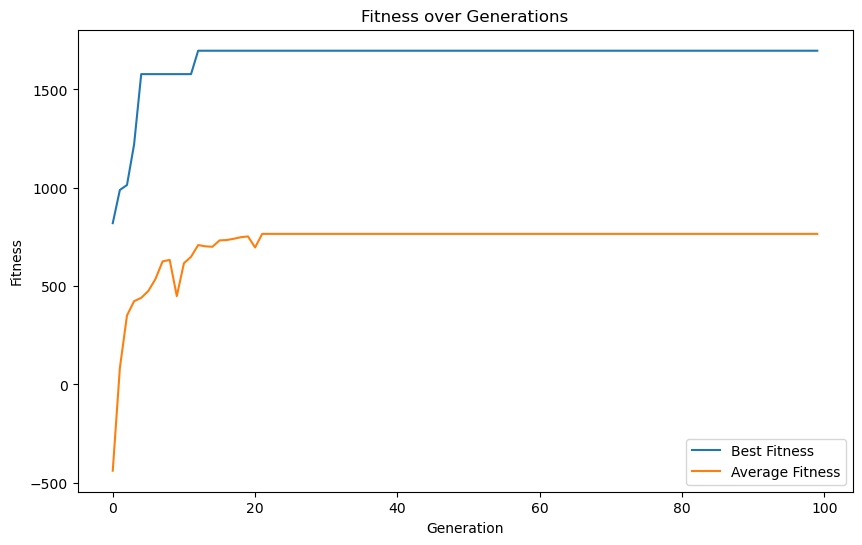

In [7]:
# Cell 6: Analyze the results

# Plot the fitness over generations
best_fitness_per_generation = [max(scores) for scores in ga.fitness_history]
avg_fitness_per_generation = [np.mean(scores) for scores in ga.fitness_history]

plt.figure(figsize=(10, 6))
plt.plot(best_fitness_per_generation, label='Best Fitness')
plt.plot(avg_fitness_per_generation, label='Average Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness over Generations')
plt.legend()
plt.show()


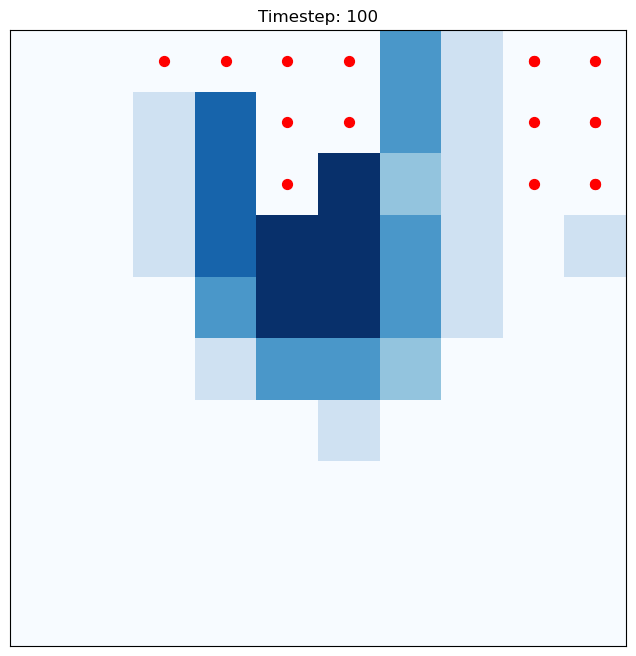

Total reward collected: 1697
Simulation ended after 100 steps.


In [9]:
# Cell 7: Run agents in the environment using the best policy with visualization options

# Extract the best policy from the last generation
best_fitness_scores = ga.fitness_history[-1]
best_policy_index = np.argmax(best_fitness_scores)
best_policy = ga.population[best_policy_index]

# Initialize the environment with visualization options
env_config.update({
    "show_paths": True,             # Set initial visualization options
    "show_comm_radius": True
})
env = SugarscapeEnv(env_config)
observations, _ = env.reset()

done = False
step = 0
total_reward = 0

while not done:
    actions = {}
    for agent_id, obs in observations.items():
        action = best_policy.act(obs)
        actions[agent_id] = action
    observations, reward_dict, terminations, truncations, _ = env.step(actions)
    reward = sum(reward_dict.values())
    total_reward += reward
    done = terminations.get('__all__', False) or truncations.get('__all__', False)
    step += 1

    # Example of toggling visualization options during simulation
    if step == 50:
        env.show_paths = False          # Disable path visualization at step 50
    if step == 75:
        env.show_comm_radius = False    # Disable communication radius visualization at step 75

    # Render the environment
    env.render()

print(f"Total reward collected: {total_reward}")
print(f"Simulation ended after {step} steps.")

# Close the environment
env.close()


In [10]:
import imageio
# Cell 7: Run agents in the environment using the best policy with visualization options

# # Extract the best policy from the last generation
# best_fitness_scores = ga.fitness_history[-1]
# best_policy_index = np.argmax(best_fitness_scores)
# best_policy = ga.population[best_policy_index]

# # Initialize the environment with visualization options
# env_config.update({
#     "show_paths": True,             # Set initial visualization options
#     "show_comm_radius": True
# })
# env = SugarscapeEnv(env_config)
# observations, _ = env.reset()

# done = False
# step = 0
# total_reward = 0

# while not done:
#     actions = {}
#     for agent_id, obs in observations.items():
#         action = best_policy.act(obs)
#         actions[agent_id] = action
#     observations, reward_dict, terminations, truncations, _ = env.step(actions)
#     reward = sum(reward_dict.values())
#     total_reward += reward
#     done = terminations.get('__all__', False) or truncations.get('__all__', False)
#     step += 1

#     # Example of toggling visualization options during simulation
#     if step == 50:
#         env.show_paths = False          # Disable path visualization at step 50
#     if step == 75:
#         env.show_comm_radius = False    # Disable communication radius visualization at step 75

#     # Render the environment (frames are saved internally)
#     env.render()

# print(f"Total reward collected: {total_reward}")
# print(f"Simulation ended after {step} steps.")

# # Close the environment
# env.close()

# # Create an animation using the collected frames
# # Option 1: Using matplotlib.animation
# from matplotlib.animation import FFMpegWriter

# metadata = dict(title='Sugarscape Simulation', artist='Matplotlib', comment='Sugarscape simulation video')
# writer = FFMpegWriter(fps=15, metadata=metadata)

# fig = plt.figure(figsize=(8, 8))
# with writer.saving(fig, "sugarscape_simulation.mp4", dpi=100):
#     for frame in env.frames:
#         plt.imshow(frame)
#         plt.axis('off')
#         writer.grab_frame()
#         plt.clf()  # Clear the figure for the next frame

# print("Simulation video saved as sugarscape_simulation.mp4")
# Close the environment
env.close()

# Use imageio to save the frames as a video
import imageio

# Convert frames to a list of images
frames = env.frames

# Save as MP4 video
imageio.mimsave('sugarscape_simulation.mp4', frames, fps=15, codec='libx264')

print("Simulation video saved as sugarscape_simulation.mp4")



AttributeError: 'SugarscapeEnv' object has no attribute 'frames'

# ATTEMPT 2 

### Refined rewards to hopefully improve generational peak performance

In [2]:
# Cell 1: Import necessary libraries

# For Jupyter Notebook, set matplotlib backend for interactive plotting
%matplotlib inline

import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from collections import deque
from scipy.spatial import cKDTree

import gymnasium as gym
from gymnasium import spaces
from matplotlib import colors
from IPython import display  # For rendering in notebooks
import imageio  # For saving the simulation as a video
import pickle  # For saving and loading the policy


In [3]:
# Cell 2: Define the Sugarscape environment with updated methods

class SugarscapeEnv(gym.Env):
    """
    Sugarscape Environment for agents to collect sugar.
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, config=None):
        super().__init__()
        if config is None:
            config = {}
        self.width = config.get('width', 50)
        self.height = config.get('height', 50)
        self.num_agents = config.get('num_agents', 100)
        self.broadcast_radius = config.get('broadcast_radius', 5)
        self.seed_value = config.get('seed', None)
        self.max_steps = config.get('max_steps', 1000)
        self.current_step = 0

        # Set random seeds for reproducibility
        if self.seed_value is not None:
            random.seed(self.seed_value)
            np.random.seed(self.seed_value)
        else:
            # Use a different seed for each episode to prevent overfitting
            seed = np.random.randint(0, 10000)
            random.seed(seed)
            np.random.seed(seed)

        # Environment parameters
        self.params = {
            'max_sugar': 5,
            'growth_rate': 1,
            'sugar_peak_frequency': 0.04,
            'sugar_peak_spread': 6,
            'job_center_duration': (40, 100),
            'vision_range': 1,
            'message_expiry': 15,
            'max_relay_messages': 10
        }

        self.job_centers = []
        self.sugar = np.zeros((self.height, self.width), dtype=int)
        self.create_initial_sugar_peaks()
        self.update_sugar_landscape()
        self.max_sugar_landscape = self.sugar.copy()

        # Define the maximum message queue length before initializing agents
        self.max_message_queue = 10

        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []
        self.timestep = 0

        # Define action and observation spaces
        self.action_space = spaces.Discrete(8)  # 8 directions (no stand still)

        # Observation space: [agent_state (4,), local_sugar (9,), messages (50,)]
        obs_space_dict = {
            'agent': spaces.Box(low=0, high=100, shape=(4,), dtype=np.float32),
            'local_sugar': spaces.Box(low=0, high=self.params['max_sugar'], shape=(9,), dtype=np.float32),
            'messages': spaces.Box(low=0, high=100, shape=(50,), dtype=np.float32)  # 10 messages x 5 attributes
        }
        self.observation_space = spaces.Dict(obs_space_dict)

        # Visualization settings
        self.show_paths = config.get('show_paths', False)
        self.show_comm_radius = config.get('show_comm_radius', False)
        self.agent_paths = {}  # Dictionary to store agent paths

        # Initialize the viewer attribute
        self.viewer = None

        # Initialize frames list for video recording
        self.frames = []

        # Custom colormap for sugar peaks (yellow)
        self.sugar_cmap = plt.cm.YlOrBr  # Yellow to brown colormap

    def create_initial_sugar_peaks(self, num_peaks=2):
        """
        Create initial sugar peaks in the environment.
        """
        for _ in range(num_peaks):
            self.create_job_center()
        self.update_sugar_landscape()

    def create_job_center(self):
        """
        Create a new job center (sugar peak) in the environment.
        """
        x, y = np.random.randint(0, self.width), np.random.randint(0, self.height)
        duration = np.random.randint(*self.params['job_center_duration'])
        self.job_centers.append({
            'x': x, 'y': y,
            'duration': duration,
            'max_sugar': self.params['max_sugar']
        })

    def update_sugar_landscape(self):
        """
        Update the sugar landscape based on current job centers.
        """
        self.sugar = np.zeros((self.height, self.width))
        for center in self.job_centers:
            x_grid, y_grid = np.meshgrid(np.arange(self.width), np.arange(self.height))
            distance = np.sqrt((x_grid - center['x']) ** 2 + (y_grid - center['y']) ** 2)
            sugar_level = center['max_sugar'] * np.exp(-distance ** 2 / (2 * self.params['sugar_peak_spread'] ** 2))
            self.sugar += sugar_level
        self.sugar = np.clip(self.sugar, 0, self.params['max_sugar'])
        self.sugar = np.round(self.sugar).astype(int)

    def initialize_agents(self):
        """
        Initialize agents at random positions in the environment.
        """
        agents = []
        available_positions = set((x, y) for x in range(self.width) for y in range(self.height))
        for i in range(self.num_agents):
            if not available_positions:
                break
            x, y = random.choice(list(available_positions))
            available_positions.remove((x, y))
            agents.append(self.create_agent(i, x, y))
        return agents

    def create_agent(self, id, x, y):
        """
        Create an agent with specified attributes.
        """
        return {
            'id': id,
            'x': x,
            'y': y,
            'sugar': np.random.randint(40, 80),
            'metabolism': np.random.randint(1, 3),
            'vision': self.params['vision_range'],
            'broadcast_radius': max(1, int(np.random.normal(self.broadcast_radius, self.broadcast_radius / 3))),
            'messages': deque(maxlen=self.max_message_queue),
            'destination': None,
            'age': 0  # Age of the agent
        }

    def get_local_sugar(self, agent):
        """
        Get the local sugar levels around the agent.
        """
        x, y = agent['x'], agent['y']
        local_sugar = np.zeros((3, 3))
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.width and 0 <= ny < self.height:
                    local_sugar[dy + 1, dx + 1] = self.sugar[ny, nx]
        return local_sugar

    def get_observation(self, agent):
        """
        Get the observation for an agent.
        """
        # Agent's own state
        agent_state = np.array([
            agent['sugar'],
            agent['metabolism'],
            agent['vision'],
            agent['broadcast_radius']
        ], dtype=np.float32)

        # Local sugar levels (flattened)
        local_sugar = self.get_local_sugar(agent).flatten()

        # Messages (flattened)
        messages = np.zeros((self.max_message_queue, 5))
        for i, msg in enumerate(list(agent['messages'])[-self.max_message_queue:]):
            messages[i] = np.array([
                msg['sender_id'],
                msg['sugar_amount'],
                msg['timestep'],
                msg['x'],
                msg['y']
            ], dtype=np.float32)
        messages = messages.flatten()

        observation = {
            'agent': agent_state,
            'local_sugar': local_sugar,
            'messages': messages
        }
        return observation

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        # Optionally handle seed and options for gymnasium compatibility
        if seed is not None:
            self.seed_value = seed
            random.seed(self.seed_value)
            np.random.seed(self.seed_value)
        else:
            # Use a different seed for each episode to prevent overfitting
            seed = np.random.randint(0, 10000)
            random.seed(seed)
            np.random.seed(seed)

        self.job_centers = []
        self.create_initial_sugar_peaks()
        self.update_sugar_landscape()
        self.agents = self.initialize_agents()
        self.agent_positions = set((agent['x'], agent['y']) for agent in self.agents)
        self.dead_agents = []
        self.timestep = 0
        self.current_step = 0

        observations = {}
        for agent in self.agents:
            agent_id = f"agent_{agent['id']}"
            observations[agent_id] = self.get_observation(agent)

        # Initialize agent paths
        self.agent_paths = {}
        for agent in self.agents:
            agent_id = f"agent_{agent['id']}"
            self.agent_paths[agent_id] = [(agent['x'], agent['y'])]

        # Clear previous frames
        self.frames = []

        return observations, {}  # Return observations and empty info

    def step(self, actions):
        """
        Perform one step in the environment.
        """
        self.timestep += 1
        self.current_step += 1

        # Update job centers
        for center in self.job_centers:
            center['duration'] -= 1
        self.job_centers = [center for center in self.job_centers if center['duration'] > 0]
        if np.random.random() < self.params['sugar_peak_frequency']:
            self.create_job_center()
        self.update_sugar_landscape()

        # Initialize return dictionaries
        rewards = {}
        terminations = {}
        truncations = {}
        infos = {}
        next_observations = {}

        # Remove agents from current positions
        self.agent_positions.clear()

        # Apply actions
        for agent in self.agents:
            agent_id = f"agent_{agent['id']}"
            action = actions.get(agent_id, random.randint(0, 7))  # Random action if none provided
            self.move_agent(agent, action)
            self.agent_positions.add((agent['x'], agent['y']))
            agent['age'] += 1  # Increase agent's age

        # Collect sugar and apply metabolism
        for agent in self.agents:
            agent_id = f"agent_{agent['id']}"
            collected_sugar = self.sugar[agent['y'], agent['x']]
            agent['sugar'] += collected_sugar
            self.sugar[agent['y'], agent['x']] = 0
            agent['sugar'] -= agent['metabolism']
            agent['sugar'] = int(agent['sugar'])  # Ensure agent sugar is integer

            # Reward: Amount of sugar collected minus metabolism cost
            # Plus a small reward for surviving another timestep
            reward = (collected_sugar - agent['metabolism']) + 1  # Survival reward
            rewards[agent_id] = reward

            # Done if agent dies
            if agent['sugar'] <= 0:
                terminations[agent_id] = True
                truncations[agent_id] = False
                infos[agent_id] = {'dead': True}
                self.dead_agents.append({'x': agent['x'], 'y': agent['y'], 'death_time': self.timestep})
            else:
                terminations[agent_id] = False
                truncations[agent_id] = False
                infos[agent_id] = {}
                next_observations[agent_id] = self.get_observation(agent)

        # Broadcast messages efficiently
        self.broadcast_messages()

        # Clean up expired messages
        for agent in self.agents:
            agent['messages'] = deque(
                [msg for msg in agent['messages'] if self.timestep - msg['timestep'] <= self.params['message_expiry']],
                maxlen=self.max_message_queue
            )

        # Remove dead agents
        self.agents = [agent for agent in self.agents if agent['sugar'] > 0]

        # Update agent positions and paths
        for agent in self.agents:
            agent_id = f"agent_{agent['id']}"
            if agent_id in self.agent_paths:
                self.agent_paths[agent_id].append((agent['x'], agent['y']))

        # Check if all agents are done
        terminations['__all__'] = self.current_step >= self.max_steps or len(self.agents) == 0
        truncations['__all__'] = False

        return next_observations, rewards, terminations, truncations, infos

    def move_agent(self, agent, action):
        """
        Move the agent based on the action taken.
        """
        # Actions mapped to movement vectors (dx, dy)
        move_map = {
            0: (0, -1),   # Up
            1: (1, -1),   # Up-Right
            2: (1, 0),    # Right
            3: (1, 1),    # Down-Right
            4: (0, 1),    # Down
            5: (-1, 1),   # Down-Left
            6: (-1, 0),   # Left
            7: (-1, -1),  # Up-Left
        }
        dx, dy = move_map.get(action, (0, 0))
        new_x = agent['x'] + dx
        new_y = agent['y'] + dy

        # Check boundaries and occupancy
        if 0 <= new_x < self.width and 0 <= new_y < self.height:
            if (new_x, new_y) not in self.agent_positions:
                agent['x'] = new_x
                agent['y'] = new_y

    def broadcast_messages(self):
        """
        Broadcast messages from agents to their neighbors within the broadcast radius.
        """
        if not self.agents:
            return  # No agents to broadcast

        # Extract agent positions
        positions = np.array([[agent['x'], agent['y']] for agent in self.agents])

        # Build cKDTree for efficient spatial queries
        tree = cKDTree(positions)

        # Query all neighbors within broadcast_radius for each agent
        all_neighbors = tree.query_ball_point(positions, self.broadcast_radius)

        for i, agent in enumerate(self.agents):
            # Create the message from this agent
            visible_sugar = self.get_local_sugar(agent).sum()
            message = {
                'sender_id': agent['id'],
                'sugar_amount': visible_sugar,
                'timestep': self.timestep,
                'x': agent['x'],
                'y': agent['y']
            }

            neighbors = all_neighbors[i]
            for neighbor_idx in neighbors:
                if neighbor_idx != i:
                    self.agents[neighbor_idx]['messages'].append(message)

    def render(self, mode='human'):
        """
        Render the environment for visualization and collect frames for video.
        """
        # Clear the previous output
        display.clear_output(wait=True)
        
        if self.viewer is None:
            # Initialize the plot
            self.fig, self.ax = plt.subplots(figsize=(8, 8))
            self.viewer = True  # Indicate that viewer is initialized

            # Create a colormap for the sugar levels (yellow)
            self.cmap = self.sugar_cmap
            self.norm = colors.Normalize(vmin=0, vmax=self.params['max_sugar'])

        # Clear the axis for the new frame
        self.ax.clear()

        # Plot the sugar landscape
        sugar_colors = self.cmap(self.norm(self.sugar))[:, :, :3]  # Ignore alpha channel
        self.ax.imshow(sugar_colors, interpolation='nearest', origin='lower')

        # Plot agent positions
        agent_x = [agent['x'] for agent in self.agents]
        agent_y = [agent['y'] for agent in self.agents]

        # Plot agents as red dots
        self.ax.scatter(agent_x, agent_y, c='red', s=50, label='Agents')

        # Optionally plot communication radius
        if self.show_comm_radius:
            for agent in self.agents:
                circle = plt.Circle((agent['x'], agent['y']), agent['broadcast_radius'],
                                    color='green', fill=False, alpha=0.3)
                self.ax.add_patch(circle)

        # Optionally plot paths
        if self.show_paths:
            for agent_id, path in self.agent_paths.items():
                if len(path) > 1:
                    x_vals, y_vals = zip(*path)
                    self.ax.plot(x_vals, y_vals, linestyle='--', linewidth=1, alpha=0.7)

        # Set plot limits and title
        self.ax.set_xlim(-0.5, self.width - 0.5)
        self.ax.set_ylim(-0.5, self.height - 0.5)
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.ax.set_title(f"Timestep: {self.current_step}")

        # Draw the current frame
        self.fig.canvas.draw()

        # Convert the canvas to a numpy array and append to frames
        image = np.frombuffer(self.fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(self.fig.canvas.get_width_height()[::-1] + (3,))
        self.frames.append(image)

        # Display the plot
        display.display(self.fig)
        plt.close(self.fig)  # Prevent duplicate figures

    def close(self):
        """
        Close the environment and clean up resources.
        """
        if self.viewer:
            plt.close(self.fig)
            self.viewer = None


In [4]:
# Cell 3: Define the AgentPolicy class

class AgentPolicy:
    """
    AgentPolicy defines how an agent acts based on observations.
    """
    def __init__(self, weights=None):
        # Define the size of the observation vector
        self.obs_size = 4 + 9 + 50  # agent_state (4,) + local_sugar (9,) + messages (50,)
        self.num_actions = 8  # 8 possible actions
        # Initialize weights
        if weights is None:
            # Random weights for initial policies
            self.weights = np.random.randn(self.num_actions, self.obs_size)
        else:
            self.weights = weights

    def act(self, observation):
        # Flatten the observation into a vector
        obs_vector = np.concatenate([
            observation['agent'],
            observation['local_sugar'],
            observation['messages']
        ])
        # Compute action probabilities
        logits = self.weights.dot(obs_vector)
        probs = self.softmax(logits)
        # Sample an action
        action = np.random.choice(self.num_actions, p=probs)
        return action

    def softmax(self, x):
        # Numerically stable softmax
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def mutate(self, mutation_rate=0.1):
        # Apply mutations to the weights
        mutation = np.random.randn(*self.weights.shape) * mutation_rate
        new_weights = self.weights + mutation
        return AgentPolicy(new_weights)

    def crossover(self, other_policy):
        # Perform crossover between two policies
        new_weights = np.copy(self.weights)
        mask = np.random.rand(*self.weights.shape) < 0.5
        new_weights[mask] = other_policy.weights[mask]
        return AgentPolicy(new_weights)

    def save(self, filename):
        # Save the policy weights to a file
        with open(filename, 'wb') as f:
            pickle.dump(self.weights, f)

    @staticmethod
    def load(filename):
        # Load the policy weights from a file
        with open(filename, 'rb') as f:
            weights = pickle.load(f)
        return AgentPolicy(weights)


In [5]:
# Cell 4: Implement the GeneticAlgorithm class

class GeneticAlgorithm:
    """
    GeneticAlgorithm manages the evolution of AgentPolicies.
    """
    def __init__(self, population_size=20, mutation_rate=0.1, elite_fraction=0.2):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.elite_fraction = elite_fraction
        self.population = [AgentPolicy() for _ in range(population_size)]
        self.fitness_history = []

    def evaluate(self, env_config, num_episodes=3):
        fitness_scores = []
        for policy in self.population:
            total_reward = 0
            for _ in range(num_episodes):
                # Use different seeds for each episode to ensure robustness
                env_config['seed'] = np.random.randint(0, 10000)
                env = SugarscapeEnv(env_config)
                observations, _ = env.reset()
                done = False
                while not done:
                    actions = {}
                    for agent_id, obs in observations.items():
                        action = policy.act(obs)
                        actions[agent_id] = action
                    observations, rewards, terminations, truncations, _ = env.step(actions)
                    done = terminations.get('__all__', False) or truncations.get('__all__', False)
                    total_reward += sum(rewards.values())
                env.close()
            average_reward = total_reward / num_episodes
            fitness_scores.append(average_reward)
        return fitness_scores

    def select_elite(self, fitness_scores):
        # Select top-performing policies
        elite_size = max(1, int(self.elite_fraction * self.population_size))
        elite_indices = np.argsort(fitness_scores)[-elite_size:]
        elites = [self.population[i] for i in elite_indices]
        return elites

    def reproduce(self, elites):
        # Generate new population from elites
        new_population = elites.copy()
        while len(new_population) < self.population_size:
            parent1, parent2 = random.sample(elites, 2)
            child = parent1.crossover(parent2)
            child = child.mutate(self.mutation_rate)
            new_population.append(child)
        return new_population

    def run(self, env_config, generations=10):
        for generation in range(generations):
            print(f"Generation {generation + 1}/{generations}")
            fitness_scores = self.evaluate(env_config)
            self.fitness_history.append(fitness_scores)
            elites = self.select_elite(fitness_scores)
            self.population = self.reproduce(elites)


In [10]:
# Cell 5: Initialize and run the Genetic Algorithm

# Environment configuration
env_config = {
    "width": 20,
    "height": 20,
    "num_agents": 50,
    "seed": 41,  # Use None to ensure diversity in random seeds
    "max_steps": 400,
    "broadcast_radius": 10
}

# Initialize the genetic algorithm
ga = GeneticAlgorithm(population_size=100, mutation_rate=0.2, elite_fraction=0.2)

# Run the genetic algorithm
ga.run(env_config, generations=200)


Generation 1/200


KeyboardInterrupt: 

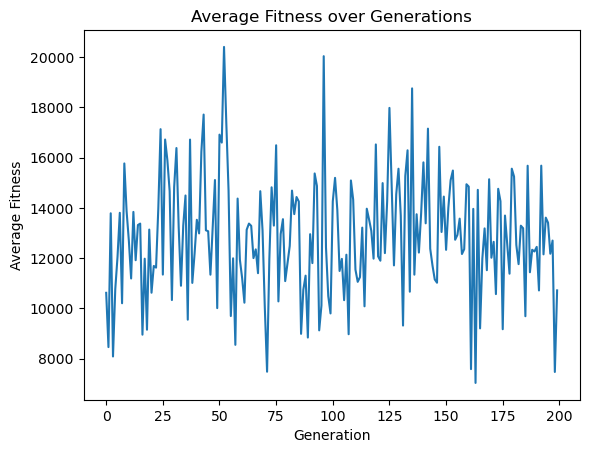

Best policy saved to 'best_policy.pkl'


In [7]:
# Cell 6: Analyze the results and save the best policy

import matplotlib.pyplot as plt

# Plot the average fitness over generations
average_fitness = [np.mean(fitness) for fitness in ga.fitness_history]
plt.figure()
plt.plot(average_fitness)
plt.xlabel('Generation')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.show()

# Save the best policy from the last generation
best_fitness_scores = ga.fitness_history[-1]
best_policy_index = np.argmax(best_fitness_scores)
best_policy = ga.population[best_policy_index]
best_policy.save('best_policy.pkl')
print("Best policy saved to 'best_policy.pkl'")


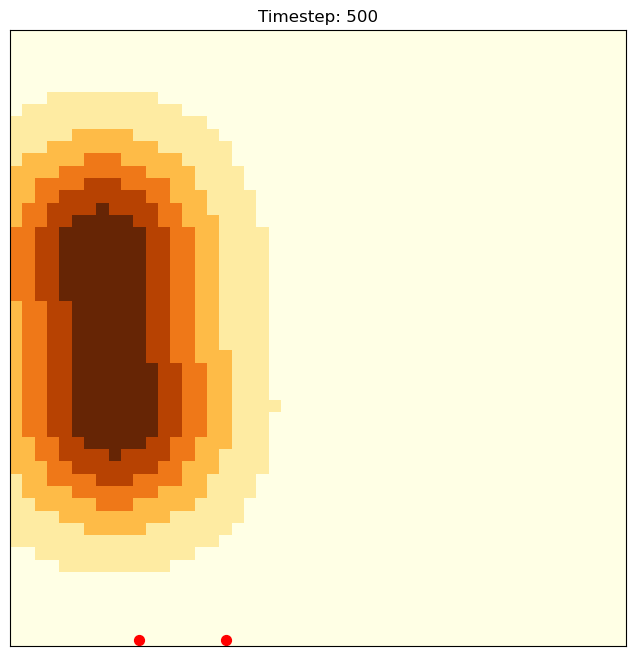

Total reward collected: 11737
Simulation ended after 500 steps.
Simulation video saved as sugarscape_simulation.mp4


In [9]:
# Cell 7: Run agents in the environment using the best policy with visualization options

# Load the best policy
best_policy = AgentPolicy.load('best_policy.pkl')

# Initialize the environment with visualization options and a specific seed
simulation_seed = 12345  # Your chosen seed for reproducibility
env_config.update({
    "show_paths": True,             # Set initial visualization options
    "show_comm_radius": True,
    "seed": simulation_seed         # Set the seed for the simulation
})
env = SugarscapeEnv(env_config)
observations, _ = env.reset(seed=simulation_seed)

done = False
step = 0
total_reward = 0

while not done:
    actions = {}
    for agent_id, obs in observations.items():
        action = best_policy.act(obs)
        actions[agent_id] = action
    observations, reward_dict, terminations, truncations, _ = env.step(actions)
    reward = sum(reward_dict.values())
    total_reward += reward
    done = terminations.get('__all__', False) or truncations.get('__all__', False)
    step += 1

    # Example of toggling visualization options during simulation
    if step == 50:
        env.show_paths = False          # Disable path visualization at step 50
    if step == 75:
        env.show_comm_radius = False    # Disable communication radius visualization at step 75

    # Render the environment (frames are saved internally)
    env.render()

print(f"Total reward collected: {total_reward}")
print(f"Simulation ended after {step} steps.")

# Close the environment
env.close()

# Create an animation using imageio and save as MP4 video
# Convert frames to a list of images
frames = env.frames

# Save as MP4 video using imageio
imageio.mimsave('sugarscape_simulation.mp4', frames, fps=15, codec='libx264')

print("Simulation video saved as sugarscape_simulation.mp4")
